In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('temperature.csv')

In [4]:
df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E


In [5]:
def parse_date(row):
    s = f"{row['year']}-{row['month']}-{row['day']}"
    return datetime.strptime(s, "%Y-%m-%d")

In [6]:
df['Date'] = df.apply(parse_date, axis=1)

In [7]:
auckland = df[df['City'] == 'Auckland'].copy().dropna()
stockholm = df[df['City'] == 'Stockholm'].copy().dropna()

In [8]:
auckland = auckland[['Date', 'AverageTemperatureFahr']].copy()
stockholm = stockholm[['Date', 'AverageTemperatureFahr']].copy()

In [10]:
# set index to date col
auckland.set_index(auckland['Date'], inplace=True)
auckland.drop('Date', axis=1, inplace=True)
auckland.columns = ['AucklandTemp']

In [11]:
auckland.head()

,AucklandTemp
Date,
1853-06-01,51.9062
1853-07-01,52.3886
1853-08-01,52.8530
1853-09-01,52.5776
1853-10-01,54.8726


In [14]:
# set index to date col
stockholm.set_index(stockholm['Date'], inplace=True)
stockholm.drop('Date', axis=1, inplace=True)
stockholm.columns = ['StockholmTemp']

In [15]:
stockholm.head()

,StockholmTemp
Date,
1743-11-01,42.8414
1744-04-01,36.8888
1744-05-01,45.1220
1744-06-01,53.1824
1744-07-01,60.0260


In [16]:
joined = auckland.join(stockholm, how='outer')

In [17]:
joined.shape

(3155, 2)

In [18]:
joined_part = joined.iloc[-500:].copy()
joined_part.index.freq = 'MS'

In [19]:
joined_part.isna().sum()

AucklandTemp     1
StockholmTemp    4
dtype: int64

In [20]:
joined_part.interpolate(inplace=True)

In [21]:
joined_part.isna().sum()

AucklandTemp     0
StockholmTemp    0
dtype: int64

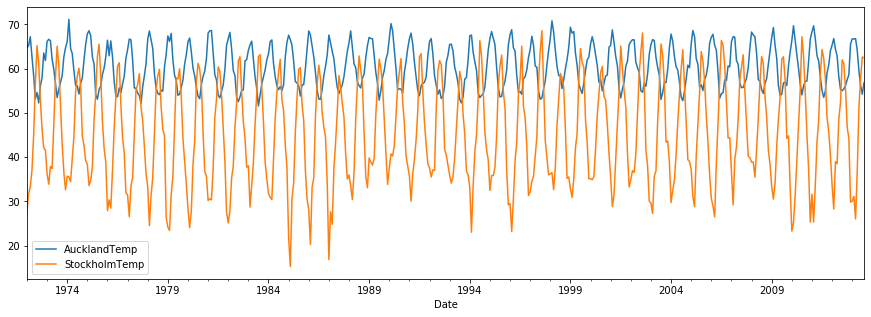

In [23]:
joined_part.plot(figsize=(15,5));

In [24]:
Ntest = 12
train = joined_part.iloc[:-Ntest].copy()
test = joined_part.iloc[-Ntest:].copy()

In [25]:
scaler_auckland = StandardScaler()
train['ScaledAuckland'] = scaler_auckland.fit_transform(train[['AucklandTemp']])
test['ScaledAuckland'] = scaler_auckland.fit_transform(test[['AucklandTemp']])

In [29]:
scaler_stockholm = StandardScaler()
train['ScaledStockholm'] = scaler_stockholm.fit_transform(train[['StockholmTemp']])
test['ScaledStockholm'] = scaler_stockholm.fit_transform(test[['StockholmTemp']])

In [30]:
train_idx = joined_part.index <= train.index[-1]
test_idx = joined_part.index > train.index[-1]

In [31]:
# put them back in original df
joined_part.loc[train_idx,'ScaledAuckland'] = train['ScaledAuckland']
joined_part.loc[test_idx,'ScaledAuckland'] = test['ScaledAuckland']
joined_part.loc[train_idx,'ScaledStockholm'] = train['ScaledStockholm']
joined_part.loc[test_idx,'ScaledStockholm'] = test['ScaledStockholm']

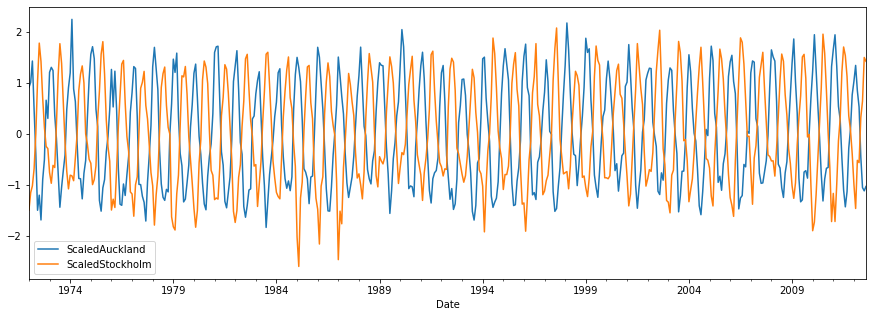

In [32]:
cols = ['ScaledAuckland','ScaledStockholm']
train[cols].plot(figsize=(15,5));

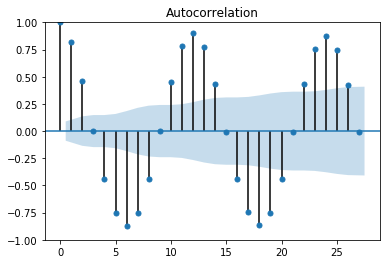

In [33]:
plot_acf(train['ScaledAuckland']);

/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


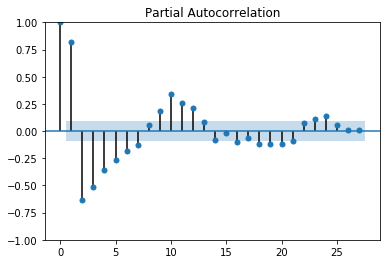

In [34]:
plot_pacf(train['ScaledAuckland']);

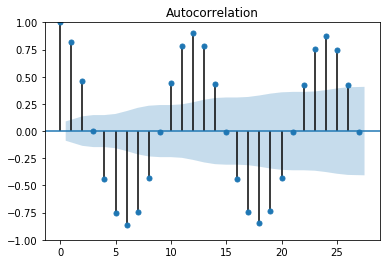

In [35]:
plot_acf(train['ScaledStockholm']);

/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


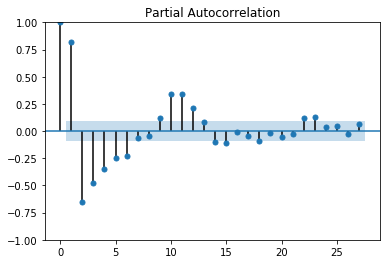

In [36]:
plot_pacf(train['ScaledStockholm']);

In [37]:
t0 = datetime.now()
model = VARMAX(train[cols], order=(10,10))
res = model.fit(maxiter=100)
print("Duration:", datetime.now() - t0)

/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Duration: 0:02:42.880679


In [38]:
fcast = res.get_forecast(Ntest)

In [39]:
res.fittedvalues['ScaledAuckland']

Date
1972-01-01   -0.000552
1972-02-01    0.847500
1972-03-01    0.728441
1972-04-01    0.821870
1972-05-01   -0.085579
                ...   
2012-04-01    0.526924
2012-05-01   -0.293310
2012-06-01   -1.071917
2012-07-01   -1.335145
2012-08-01   -1.055231
Freq: MS, Name: ScaledAuckland, Length: 488, dtype: float64

In [42]:
joined_part.loc[train_idx, 'Train Pred Auckland'] = \
    res.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test Pred Auckland'] = \
    fcast.predicted_mean['ScaledAuckland']

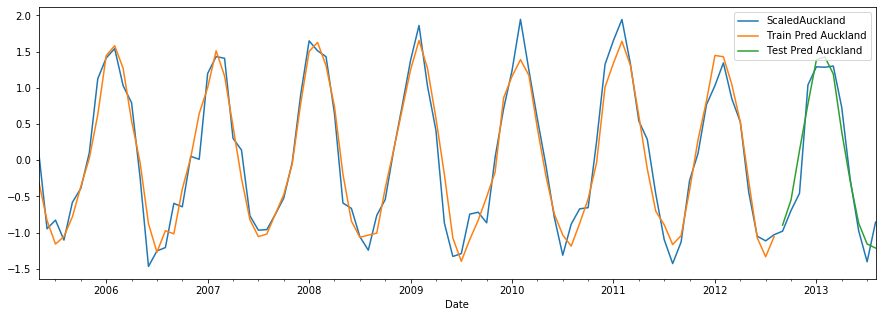

In [43]:
plot_cols = ['ScaledAuckland','Train Pred Auckland', 'Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15,5));

In [45]:
joined_part.loc[train_idx, 'Train Pred Stockholm'] = \
    res.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx, 'Test Pred Stockholm'] = \
    fcast.predicted_mean['ScaledStockholm']

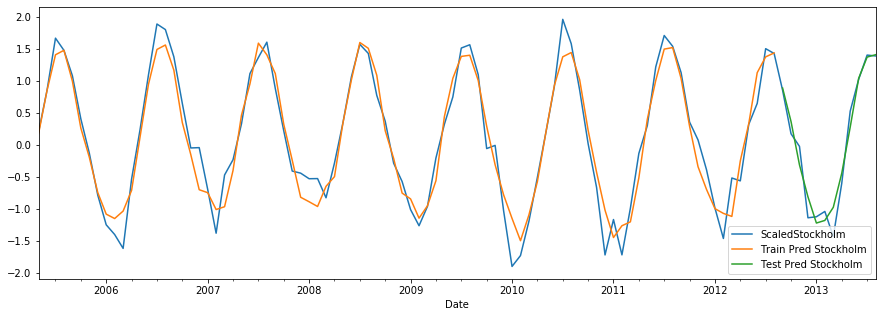

In [46]:
plot_cols = ['ScaledStockholm','Train Pred Stockholm', 'Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15,5));

In [47]:
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']
print("Auckland Train R^2:", r2_score(y_true, y_pred))

Auckland Train R^2: 0.9295393820655613


In [48]:
y_pred = joined_part.loc[test_idx, 'Test Pred Auckland']
y_true = joined_part.loc[test_idx, 'ScaledAuckland']
print("Auckland Test R^2:", r2_score(y_true, y_pred))

Auckland Test R^2: 0.9332139521533744


In [49]:
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']
print("Stockholm Train R^2:", r2_score(y_true, y_pred))

Stockholm Train R^2: 0.9247365209037021


In [50]:
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']
print("Stockholm Test R^2:", r2_score(y_true, y_pred))

Stockholm Test R^2: 0.9247365209037021


VAR

In [51]:
model = VAR(train[cols])

In [52]:
lag_order_results = model.select_order(maxlags=15)
lag_order_results

In [53]:
lag_order_results.selected_orders

{'aic': 12, 'bic': 6, 'hqic': 11, 'fpe': 12}

In [55]:
results = model.fit(maxlags=15, ic='aic')

In [56]:
lag_order = results.k_ar

In [57]:
lag_order

12

In [59]:
prior = train.iloc[-lag_order:][cols].to_numpy()
fcast = results.forecast(prior, Ntest)

In [63]:
fcast

array([[-0.86491205,  0.9126215 ],
       [-0.46098815,  0.41187248],
       [ 0.06315052, -0.18716887],
       [ 0.67626557, -0.76482676],
       [ 1.14208172, -1.07130218],
       [ 1.22700523, -1.0937979 ],
       [ 0.9794002 , -0.80403685],
       [ 0.41338843, -0.40868501],
       [-0.20952007,  0.21598454],
       [-0.78821337,  0.85620681],
       [-1.10693186,  1.24994289],
       [-1.13507881,  1.24097996]])

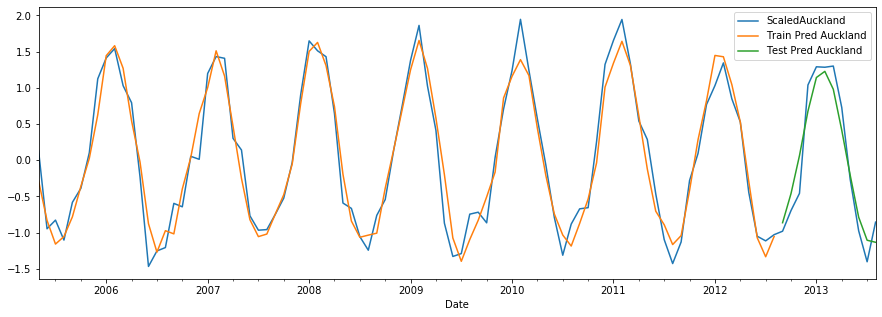

In [60]:
joined_part.loc[train_idx, 'Train Pred Auckland'] = \
    res.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test Pred Auckland'] = \
    fcast[:,0]

plot_cols = ['ScaledAuckland','Train Pred Auckland', 'Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15,5));

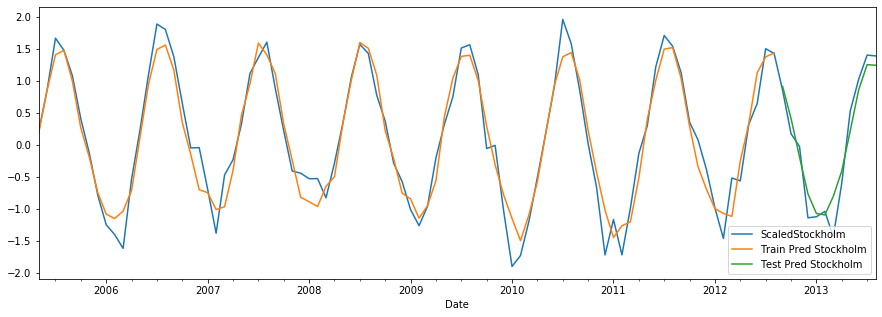

In [62]:
joined_part.loc[train_idx, 'Train Pred Stockholm'] = \
    res.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx, 'Test Pred Stockholm'] = \
    fcast[:,1]

plot_cols = ['ScaledStockholm','Train Pred Stockholm', 'Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15,5));

In [64]:
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("Auckland Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Auckland']
y_true = joined_part.loc[test_idx, 'ScaledAuckland']
print("Auckland Test R^2:", r2_score(y_true, y_pred))

Auckland Train R^2: 0.934156005495471
Auckland Test R^2: 0.9246574123704446


In [65]:
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("Stockholm Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Stockholm']
y_true = joined_part.loc[test_idx, 'ScaledStockholm']
print("Stockholm Test R^2:", r2_score(y_true, y_pred))

Stockholm Train R^2: 0.9300321014316921
Stockholm Test R^2: 0.9308706437182528


ARIMA Baseline

In [66]:
from statsmodels.tsa.arima.model import ARIMA

In [69]:
for col in cols:
    model = ARIMA(train[col], order=(10,0,10))
    res = model.fit()
    fcast = res.get_forecast(Ntest)
    print(f"{col} Train R^2:", r2_score(joined_part.loc[train_idx, col], res.fittedvalues))
    print(f"{col} Test R^2:", r2_score(joined_part.loc[test_idx, col], fcast.predicted_mean))

/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ScaledAuckland Train R^2: 0.9213764742861313
ScaledAuckland Test R^2: 0.945293335516841
ScaledStockholm Train R^2: 0.9207169246013347
ScaledStockholm Test R^2: 0.9627415423313634


/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
